## Import Libraries 


In [64]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from plotly.subplots import make_subplots
from Standardization import metric_normalizer
from sklearn.model_selection import train_test_split
from IPython.display import display, HTML
pd.set_option('display.max_columns', None)
display(HTML("<style>.container { width:100% !important; }</style>"))

import numpy as np
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler
from sklearn.decomposition import PCA 
from sklearn.pipeline import Pipeline 
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

## Read Data 




In [49]:
df = pd.read_csv('/home/clivence/base_jupyter/Datadump/Model_Data/GU_Model_Data_V1_16k')

## Data Cleaning 

In [50]:
#Filter out negative values - evetually need to research why this is happening 
df  = df[(df['2D Low in Pips'] > 0) | (df['2D Low in Pips'] > 0)] 

df = df[df['Action'] == 'Ultimate Action']
df = df[df['Ticker'] == 'GBP/USD']

df.fillna(0, inplace=True)

#Standardize the dataset
df =  metric_normalizer(df)

#Set date to datetime 
df['Date'] = pd.to_datetime(df['Date'])

#Create Date Derived Features 
df['Trade_Week_Year'] = df['Date'].dt.isocalendar().week
df['Trade_Week_Month'] = (df['Date'].dt.day -1)//7+1
df['Trade_Day_Week'] = df['Date'].dt.weekday + 1

#Create a new feature to identify the status of the previous trade 
df['Previous_Trade_Status'] = df['2D Trade Status'].shift(fill_value=0)

In [51]:
# import plotly.graph_objects as go

# # Create a list of colors based on the 'color_column'
# colors = ['green' if val == 'BUY' else 'RED' for val in df['Order Type']]

# fig = go.Figure(data=go.Scatter(
#     x=df['Date'],  # Access the 'x' column
#     y=df['2D High in Pips'],  # Access the 'y' column
#     mode='markers',
#     marker=dict(
#         size=10,
#         color=colors,  # Map colors from the 'color_column'
#         opacity=0.8
#     )
# ))

# # Customize the layout
# fig.update_layout(
#     title="Order Type by Date",
#     xaxis_title="Date",
#     yaxis_title="2D High In Pips",
# #     grid=True
# )
# fig.show()

In [52]:
# # Create a list of colors based on the 'color_column'
# # colors = ['green' if val == 'BUY' else 'RED' for val in df['Order Type']]

# fig = go.Figure(data=go.Scatter(
#     x=df['close'],  # Access the 'x' column
#     y=df['2D High in Pips'],  # Access the 'y' column
#     mode='markers',
#     marker=dict(
#         size=10,
#         color=colors,  # Map colors from the 'color_column'
#         opacity=0.8
#     )
# ))

# # Customize the layout
# fig.update_layout(
#     title="Scatter Plot from DataFrame",
#     xaxis_title="Close",
#     yaxis_title="2D High In Pips",
# #     grid=True
# )
# fig.show()

## Data Preprocessing 


In [60]:
#Subset Selection
X= df[['open', 'high', 'low', 'close', 'volume','Trade_Week_Year','Trade_Week_Month','Trade_Day_Week',
       'Day','Month','Time','25EMA', '50EMA', '75EMA','100EMA', '125EMA',
        'Trend Status', 'Spread','5075 Trend Status', '75100 Trend Status',
       '100125 Trend Status', 'Action', 'Opportunity', 'Order Type', 
        '%K', '%D', 'k_group', 'ADX', 'ADXR', 'slowk','slowd','CDL2CROWS', 'CDL3BLACKCROWS',
        'CDL3INSIDE', 'CDL3LINESTRIKE', 'CDL3OUTSIDE',
        'CDL3STARSINSOUTH', 'CDL3WHITESOLDIERS', 'CDLABANDONEDBABY', 'CDLADVANCEBLOCK',
        'CDLBELTHOLD', 'CDLBREAKAWAY', 'CDLCLOSINGMARUBOZU', 'CDLCONCEALBABYSWALL',
        'CDLCOUNTERATTACK', 'CDLDARKCLOUDCOVER', 'CDLDOJI', 'CDLDOJISTAR', 'CDLDRAGONFLYDOJI',
        'CDLENGULFING', 'CDLEVENINGDOJISTAR', 'CDLEVENINGSTAR', 'CDLGAPSIDESIDEWHITE',
        'CDLGRAVESTONEDOJI', 'CDLHAMMER', 'CDLHANGINGMAN', 'CDLHARAMI', 'CDLHARAMICROSS',
        'CDLHIGHWAVE', 'CDLHIKKAKE', 'CDLHIKKAKEMOD', 'CDLHOMINGPIGEON', 'CDLIDENTICAL3CROWS',
        'CDLINNECK', 'CDLINVERTEDHAMMER', 'CDLKICKING', 'CDLKICKINGBYLENGTH', 'CDLLADDERBOTTOM',
        'CDLLONGLEGGEDDOJI', 'CDLLONGLINE', 'CDLMARUBOZU', 'CDLMATCHINGLOW', 'CDLMATHOLD',
        'CDLMORNINGDOJISTAR', 'CDLMORNINGSTAR', 'CDLONNECK', 'CDLPIERCING', 'CDLRICKSHAWMAN',
        'CDLRISEFALL3METHODS', 'CDLSEPARATINGLINES', 'CDLSHOOTINGSTAR', 'CDLSHORTLINE',
        'CDLSPINNINGTOP', 'CDLSTALLEDPATTERN', 'CDLSTICKSANDWICH', 'CDLTAKURI', 'CDLTASUKIGAP',
        'CDLTHRUSTING', 'CDLTRISTAR', 'CDLUNIQUE3RIVER', 'CDLUPSIDEGAP2CROWS', 'CDLXSIDEGAP3METHODS',
        'candle_bullish_score','candle_bearish_score','Previous_Trade_Status']]
Y = df[['2D High in Pips']]


#Create a list of columns to encode 
cat_cols_to_encode = ['Time','Trend Status','5075 Trend Status', '75100 Trend Status',
                    '100125 Trend Status', 'Action', 'Opportunity', 'Order Type',
                    'k_group']
#Create a list of cols for ordinal encoding 
cat_cols_for_ordinal_encoding = []

#Create a list of cols to scale 
num_cols_to_scale = ['volume']

#View row, cols count
df.shape ,  X.shape, Y.shape

((483, 96), (483, 95), (483, 1))

In [62]:
 #Split the data into training and test set 
X_train, X_test, y_train, y_test = train_test_split( X, Y, test_size=.204, random_state=42, stratify=X['Order Type'])

print(f"Training Set: {X_train.shape}\
        \nTest Set: {X_test.shape}")

Training Set: (384, 95)       
Test Set: (99, 95)


### Build Baseline Model 

In [75]:
average_2d_high_pips= y_train['2D High in Pips'].mean()
baseline_model_test_predictions = [average_2d_high_pips] * len(y_test)

mean_absolute_error(baseline_model_test_predictions, y_test)

51.01187657828274

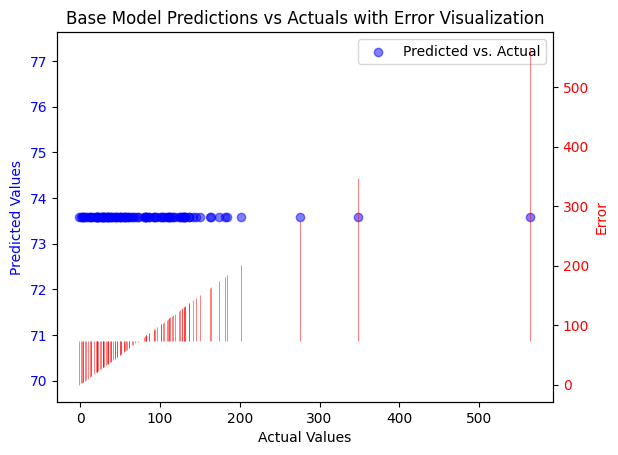

In [71]:
def custom_combiner(feature, ):
    name = 'encoded'
    return str(name)+ "_" + str(feature)

#Create Column Tranformer 
Preprocessor = make_column_transformer(
                                (StandardScaler(), num_cols_to_scale),
                                (OneHotEncoder(feature_name_combiner=custom_combiner,drop='first',sparse_output=False),cat_cols_to_encode,{'prefix':'encoded'}),
#                                 (OrdinalEncoder(), cat_cols_for_ordinal_encoding),
                                remainder='passthrough')

# Preprocessor.set_output(transform='pandas')

#Create Pieline to be used in Model
Model_Pipeline = Pipeline(steps=[
    ('Preprocessor', Preprocessor),
    ('RF_Model',RandomForestRegressor(n_estimators=100, max_depth=5))])

#View Pipeline 
Model_Pipeline

Pipeline(steps=[('Preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['volume']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='first',
                                                                feature_name_combiner=<function custom_combiner at 0x7b9f7f5b1ca0>,
                                                                sparse_output=False),
                                                  ['Time', 'Trend Status',
                                                   '5075 Trend Status',
                                                   '75100 Trend Status',
                                                   '100125 Trend Status',
                                                   'Action', 'Opportunity',
                                                   'Order Type',
                                                   'k_group'])])),
                ('RF_Model', RandomForestRegressor(max_depth=5))])

In [73]:
#Fit the training data 
Model_Pipeline.fit(X_train, y_train)

#Make Predictions on the test set 
RF_Model_Predictions = Model_Pipeline.predict(X_test)

#Get Error Metrics of Random Forest Model
mean_absolute_error(y_test, RF_Model_Predictions)

/home/clivence/base_jupyter/venv/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



50.113195425775515

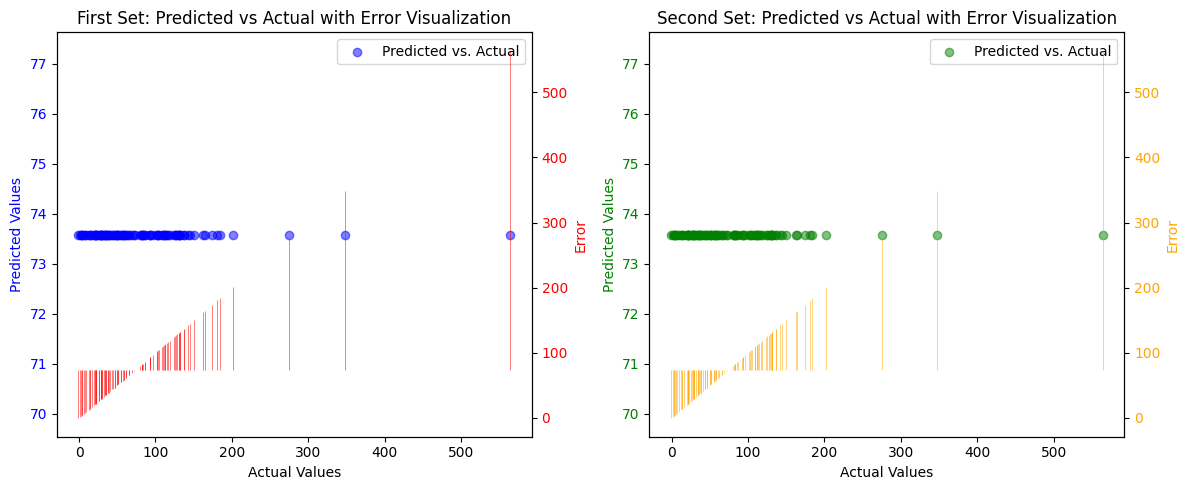

In [80]:
import numpy as np
import matplotlib.pyplot as plt

# Sample data for the second set (make a copy)
actual2 = np.array(y_test)  
predicted2 = np.array(baseline_model_test_predictions)

# Calculate the errors for the second set
errors2 = actual2 - predicted2

# Create the primary plot with scatter points for the first set
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# First subplot (1, 2, 1)
ax1 = axs[0]
ax1.scatter(actual, predicted, alpha=0.5, color='blue', label='Predicted vs. Actual')
ax1.set_xlabel('Actual Values')
ax1.set_ylabel('Predicted Values', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.legend()
ax1.set_title('First Set: Predicted vs Actual with Error Visualization')

# Create the secondary y-axis for errors
ax2 = ax1.twinx()  
ax2.set_ylabel('Error', color='red')  
ax2.tick_params(axis='y', labelcolor='red')

# Adding vertical lines for each point to represent the error
for i in range(len(actual)):
    plt.vlines(actual[i], predicted[i], actual[i], color='red', alpha=0.7, linewidth=0.5)

# Second subplot (1, 2, 2)
ax2 = axs[1]
ax2.scatter(actual2, predicted2, alpha=0.5, color='green', label='Predicted vs. Actual')
ax2.set_xlabel('Actual Values')
ax2.set_ylabel('Predicted Values', color='green')
ax2.tick_params(axis='y', labelcolor='green')
ax2.legend()
ax2.set_title('Second Set: Predicted vs Actual with Error Visualization')

# Create the secondary y-axis for errors for the second set
ax3 = ax2.twinx()  
ax3.set_ylabel('Error', color='orange')  
ax3.tick_params(axis='y', labelcolor='orange')

# Adding vertical lines for each point to represent the error for the second set
for i in range(len(actual2)):
    plt.vlines(actual2[i], predicted2[i], actual2[i], color='orange', alpha=0.7, linewidth=0.5)

# Adjust layout for better spacing
plt.tight_layout()

plt.show()


# Follow Everything From Tutorial

In [ ]:
df_model = df_model.sample(frac=1, random_state=42)
train_df = df_model[:386]
train_df = train_df.reset_index(drop=True)

test_df = df_model[386:]
test_df = test_df.reset_index(drop=True)

In [ ]:
y_train = train_df['remainder__2D High in Pips'].to_numpy()
y_test = test_df['remainder__2D High in Pips'].to_numpy()

y_train.shape, y_test.shape

In [ ]:

from sklearn.metrics import mean_absolute_error

average_median_house_value = train_df['remainder__2D High in Pips'].mean()
baseline_model_test_predictions = [average_median_house_value] * len(test_df)

mean_absolute_error(baseline_model_test_predictions, y_test)

In [ ]:

import matplotlib.pyplot as plt
import numpy as np

# Sample data - replace with your actual and predicted values
actual = np.array(y_test)  # Assuming y_test is your actual values
predicted = np.array(baseline_model_test_predictions)  # Your predicted values
errors = actual - predicted  # Calculate the errors

# Create the primary plot with scatter points
fig, ax1 = plt.subplots()

# Scatter plot for actual vs. predicted values
ax1.scatter(actual, predicted, alpha=0.5, color='blue', label='Predicted vs. Actual')
ax1.set_xlabel('Actual Values')
ax1.set_ylabel('Predicted Values', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create the secondary y-axis for errors
ax2 = ax1.twinx()  
ax2.set_ylabel('Error', color='red')  
ax2.tick_params(axis='y', labelcolor='red')

# Adding vertical lines for each point to represent the error
for i in range(len(actual)):
    plt.vlines(actual[i], predicted[i], actual[i], color='red', alpha=0.7, linewidth=0.5)

# Optional: Add legend
ax1.legend()

plt.title('Base Model Predictions vs Actuals with Error Visualization')
plt.show()


### PCA

In [ ]:
train_df[['onehotencoder__Trend Status_Bullish',
 'onehotencoder__5075 Trend Status_Bullish',
 'onehotencoder__75100 Trend Status_Bullish',
 'onehotencoder__100125 Trend Status_Bullish',
 'onehotencoder__Opportunity_Unfavorable',
 'onehotencoder__Order Type_SELL',
 'onehotencoder__k_group_Oversold',
 'onehotencoder__k_group_Undersold',
 'onehotencoder__k_group_slightly_oversold',
 'remainder__open',
 'remainder__high',
 'remainder__low',
 'remainder__close',
 'remainder__volume',
 'remainder__Trade_Week_Year',
 'remainder__Trade_Week_Month',
 'remainder__Trade_Day_Week',
 'remainder__Day',
 'remainder__Month',
 'remainder__25EMA',
 'remainder__50EMA',
 'remainder__75EMA',
 'remainder__100EMA',
 'remainder__125EMA',
 'remainder__Spread',
 'remainder__%K',
 'remainder__%D',
 'remainder__ADX',
 'remainder__ADXR',
 'remainder__slowk',
 'remainder__slowd',
'remainder__candle_bullish_score',
 'remainder__candle_bearish_score',
'remainder__Previous_Trade_Status']].corr()

In [ ]:
X_train_34 = train_df[['onehotencoder__Trend Status_Bullish',
 'onehotencoder__5075 Trend Status_Bullish',
 'onehotencoder__75100 Trend Status_Bullish',
 'onehotencoder__100125 Trend Status_Bullish',
 'onehotencoder__Opportunity_Unfavorable',
 'onehotencoder__Order Type_SELL',
 'onehotencoder__k_group_Oversold',
 'onehotencoder__k_group_Undersold',
 'onehotencoder__k_group_slightly_oversold',
 'remainder__open',
 'remainder__high',
 'remainder__low',
 'remainder__close',
 'remainder__volume',
 'remainder__Trade_Week_Year',
 'remainder__Trade_Week_Month',
 'remainder__Trade_Day_Week',
 'remainder__Day',
 'remainder__Month',
 'remainder__25EMA',
 'remainder__50EMA',
 'remainder__75EMA',
 'remainder__100EMA',
 'remainder__125EMA',
 'remainder__Spread',
 'remainder__%K',
 'remainder__%D',
 'remainder__ADX',
 'remainder__ADXR',
 'remainder__slowk',
 'remainder__slowd',
'remainder__candle_bullish_score',
 'remainder__candle_bearish_score',
 'remainder__Previous_Trade_Status']].to_numpy()

X_train_34.shape

In [ ]:
X_test_34 = test_df[['onehotencoder__Trend Status_Bullish',
 'onehotencoder__5075 Trend Status_Bullish',
 'onehotencoder__75100 Trend Status_Bullish',
 'onehotencoder__100125 Trend Status_Bullish',
 'onehotencoder__Opportunity_Unfavorable',
 'onehotencoder__Order Type_SELL',
 'onehotencoder__k_group_Oversold',
 'onehotencoder__k_group_Undersold',
 'onehotencoder__k_group_slightly_oversold',
 'remainder__open',
 'remainder__high',
 'remainder__low',
 'remainder__close',
 'remainder__volume',
 'remainder__Trade_Week_Year',
 'remainder__Trade_Week_Month',
 'remainder__Trade_Day_Week',
 'remainder__Day',
 'remainder__Month',
 'remainder__25EMA',
 'remainder__50EMA',
 'remainder__75EMA',
 'remainder__100EMA',
 'remainder__125EMA',
 'remainder__Spread',
 'remainder__%K',
 'remainder__%D',
 'remainder__ADX',
 'remainder__ADXR',
 'remainder__slowk',
 'remainder__slowd',
'remainder__candle_bullish_score',
 'remainder__candle_bearish_score',
'remainder__Previous_Trade_Status']].to_numpy()

X_test_34.shape

In [ ]:

forest_base = RandomForestRegressor(n_estimators=100, max_depth=5).fit(X_train_34, y_train)
forest_base_test_predictions = forest_base.predict(X_test_34)
mean_absolute_error(y_test, forest_base_test_predictions)

In [ ]:
# Plotting scatter plot
plt.scatter(y_test, forest_base_test_predictions, alpha=0.5)
plt.title('Scatter Plot of Predictions vs Actuals')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

In [ ]:
# Sample data - replace with your actual and predicted values
actual = np.array(y_test)  # Assuming y_test is your actual values
predicted = np.array(forest_base_test_predictions)  # Your predicted values
errors = actual - predicted  # Calculate the errors

# Create the primary plot with scatter points
fig, ax1 = plt.subplots()

# Scatter plot for actual vs. predicted values
ax1.scatter(actual, predicted, alpha=0.5, color='blue', label='Predicted vs. Actual')
ax1.set_xlabel('Actual Values')
ax1.set_ylabel('Predicted Values', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create the secondary y-axis for errors
ax2 = ax1.twinx()  
ax2.set_ylabel('Error', color='red')  
ax2.tick_params(axis='y', labelcolor='red')

# Adding vertical lines for each point to represent the error
for i in range(len(actual)):
    plt.vlines(actual[i], predicted[i], actual[i], color='red', alpha=0.7, linewidth=0.5)

# Optional: Add legend
ax1.legend()

plt.title('Random Forest Model Predictions vs Actuals with Error Visualization')
plt.show()

In [ ]:
from sklearn.decomposition import PCA 
from sklearn.pipeline import Pipeline 


In [ ]:
pca = PCA(n_components=32)
pca = pca.fit(X_train_34)

pca

In [ ]:
X_train_pca = pca.transform(X_train_34)
X_test_pca = pca.transform(X_test_34)

X_train_pca.shape, X_test_pca.shape

In [ ]:
# Get error of Random Forest training on (X_train_pca, y_train) and testing on (X_test_pca, y_test)

forest_pca = RandomForestRegressor(n_estimators=100, max_depth=5).fit(X_train_pca, y_train)
forest_pca_test_predictions = forest_pca.predict(X_test_pca)

mean_absolute_error(y_test, forest_pca_test_predictions)

In [ ]:
from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler

In [ ]:
#Test Different Preprocessing Functions on Subset 
Scaler = Normalizer().fit(X_train_34)

X_train_34_scaled = Scaler.transform(X_train_34)

plt.hist(X_train_34_scaled[:,8])

In [ ]:
#Preprocess X_test 
X_test_34_scaled = Scaler.transform(X_test_34)

X_test_34_scaled.shape


In [ ]:
#Get error for RF Model training with scaled data and testing on scaled data 

RF_Model_Scaled = RandomForestRegressor(n_estimators=100, max_depth=5).fit(X_train_34_scaled, y_train)

RF_Model_Scaled_Predictions =  RF_Model_Scaled.predict(X_test_34_scaled)

mean_absolute_error(y_test, RF_Model_Scaled_Predictions)

In [ ]:
#Create a Pipeline of Standardization, PCA, Random Forest 


Scaled_PCA_Pipeline_RF = Pipeline(
                                steps=[('Scaler', Normalizer()),
                                       ('PCA', PCA(n_components=32)),
                                       ('RF', RandomForestRegressor(n_estimators=100, max_depth=5))])

Scaled_PCA_Pipeline_RF

In [ ]:
Scaled_PCA_Pipeline_RF.fit(X_train_34, y_train)

Scaled_PCA_Pipeline_RF_Predictions = Scaled_PCA_Pipeline_RF.predict(X_test_34)

mean_absolute_error(y_test, Scaled_PCA_Pipeline_RF_Predictions)

In [ ]:
#Create a Pipeline of Standardization, PCA, Random Forest 

from sklearn.pipeline import Pipeline 

Scaled_PCA_Pipeline_RF = Pipeline(
                                steps=[('Encoder', )
                                       ('Scaler', Normalizer()),
                                       ('PCA', PCA(n_components=32)),
                                       ('RF', RandomForestRegressor(n_estimators=100, max_depth=5))])

Scaled_PCA_Pipeline_RF

# Build a Model Based on the Encoded Features  

In [ ]:
X_train_Dummies = train_df[['onehotencoder__Time_02:00:00', 'onehotencoder__Time_05:00:00',
       'onehotencoder__Time_06:00:00', 'onehotencoder__Time_09:00:00',
       'onehotencoder__Time_10:00:00', 'onehotencoder__Time_13:00:00',
       'onehotencoder__Time_14:00:00', 'onehotencoder__Time_17:00:00',
       'onehotencoder__Time_18:00:00', 'onehotencoder__Time_21:00:00',
       'onehotencoder__Time_22:00:00', 'onehotencoder__Trend Status_Bullish',
       'onehotencoder__5075 Trend Status_Bullish',
       'onehotencoder__75100 Trend Status_Bullish',
       'onehotencoder__100125 Trend Status_Bullish',
       'onehotencoder__Opportunity_Unfavorable',
       'onehotencoder__Order Type_SELL', 'onehotencoder__k_group_Oversold',
       'onehotencoder__k_group_Undersold',
       'onehotencoder__k_group_slightly_oversold']]

X_test_Dummies = test_df[['onehotencoder__Time_02:00:00', 'onehotencoder__Time_05:00:00',
       'onehotencoder__Time_06:00:00', 'onehotencoder__Time_09:00:00',
       'onehotencoder__Time_10:00:00', 'onehotencoder__Time_13:00:00',
       'onehotencoder__Time_14:00:00', 'onehotencoder__Time_17:00:00',
       'onehotencoder__Time_18:00:00', 'onehotencoder__Time_21:00:00',
       'onehotencoder__Time_22:00:00', 'onehotencoder__Trend Status_Bullish',
       'onehotencoder__5075 Trend Status_Bullish',
       'onehotencoder__75100 Trend Status_Bullish',
       'onehotencoder__100125 Trend Status_Bullish',
       'onehotencoder__Opportunity_Unfavorable',
       'onehotencoder__Order Type_SELL', 'onehotencoder__k_group_Oversold',
       'onehotencoder__k_group_Undersold',
       'onehotencoder__k_group_slightly_oversold']]




In [ ]:
X_train_Dummies.shape, X_test_Dummies.shape

In [ ]:
y_train.shape, y_test.shape

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
#Create Linear Regresion Model
Lin_Reg_Dummy_model = LinearRegression().fit(X_train_Dummies, y_train)
Lin_Reg_Dummy_Prediction = Lin_Reg_Dummy_model.predict(X_test_Dummies)

mean_absolute_error(y_test, Lin_Reg_Dummy_Prediction)

## Binning (Grouping Aggregating )

In [ ]:
train_df['remainder__2D High in Pips'].hist()

### Cluster 

In [ ]:
plt.scatter(df['Trade_Week_Year'], df['volume'])

In [ ]:
from sklearn.cluster import KMeans

X_Train_Trade_Week_Year_Volume = train_df[['remainder__Trade_Week_Year','remainder__volume']]

KMeans = KMeans(n_clusters=7).fit(X_Train_Trade_Week_Year_Volume)

KMeans.labels_

In [ ]:
import plotly.express as px

In [ ]:

import plotly.io as pio
pio.renderers.default = "notebook_connected"


px.scatter(x=train_df['remainder__Trade_Week_Year'], y=train_df['remainder__volume'], color=KMeans.labels_)

In [ ]:
X_train_Cluster = pd.get_dummies(pd.Series(KMeans.labels_)).astype(int).to_numpy()


#Predict the clusters for the Test date 
X_Test_Trade_Week_Year_Volume = test_df[['remainder__Trade_Week_Year','remainder__volume']].to_numpy()
X_Test_Cluster = pd.get_dummies(pd.Series(KMeans.predict(X_Test_Trade_Week_Year_Volume))).astype(int).to_numpy()


Lin_Reg_Cluster  = LinearRegression().fit(X_train_Cluster, y_train)
Lin_Reg_Cluster_Predictions = Lin_Reg_Cluster.predict(X_Test_Cluster)

mean_absolute_error(y_test, Lin_Reg_Cluster_Predictions)

In [ ]:
import pandas as pd

# Assume n_clusters is the number of clusters you used
n_clusters = max(KMeans.labels_.max(), KMeans.predict(X_Test_Trade_Week_Year_Volume).max()) + 1
all_possible_clusters = pd.Series(range(n_clusters))

# For training data
X_train_Cluster = pd.get_dummies(pd.Categorical(pd.Series(KMeans.labels_), categories=all_possible_clusters)).astype(int).to_numpy()

# For test data
test_clusters = KMeans.predict(X_Test_Trade_Week_Year_Volume)
X_Test_Cluster = pd.get_dummies(pd.Categorical(pd.Series(test_clusters), categories=all_possible_clusters)).astype(int).to_numpy()


In [ ]:
Lin_Reg_Cluster  = LinearRegression().fit(X_train_Cluster, y_train)
Lin_Reg_Cluster_Predictions = Lin_Reg_Cluster.predict(X_Test_Cluster)

mean_absolute_error(y_test, Lin_Reg_Cluster_Predictions)

In [ ]:
# Plotting scatter plot
plt.scatter(y_test, Lin_Reg_Cluster_Predictions, alpha=0.5)
plt.title('Scatter Plot of Predictions vs Actuals')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

In [ ]:
# Sample data - replace with your actual and predicted values
actual = np.array(y_test)  # Assuming y_test is your actual values
predicted = np.array(Lin_Reg_Cluster_Predictions)  # Your predicted values
errors = actual - predicted  # Calculate the errors

# Create the primary plot with scatter points
fig, ax1 = plt.subplots()

# Scatter plot for actual vs. predicted values
ax1.scatter(actual, predicted, alpha=0.5, color='blue', label='Predicted vs. Actual')
ax1.set_xlabel('Actual Values')
ax1.set_ylabel('Predicted Values', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create the secondary y-axis for errors
ax2 = ax1.twinx()  
ax2.set_ylabel('Error', color='red')  
ax2.tick_params(axis='y', labelcolor='red')

# Adding vertical lines for each point to represent the error
for i in range(len(actual)):
    plt.vlines(actual[i], predicted[i], actual[i], color='red', alpha=0.7, linewidth=0.5)

# Optional: Add legend
ax1.legend()

plt.title('Random Forest Model Predictions vs Actuals with Error Visualization')
plt.show()

In [ ]:
RF_Cluster  = RandomForestRegressor(n_estimators=100, max_depth=5).fit(X_train_Cluster, y_train)
RF_Cluster_Predictions = RF_Cluster.predict(X_Test_Cluster)

mean_absolute_error(y_test, RF_Cluster_Predictions)

### Feature Selection 

In [ ]:
X_train_Cluster.shape, X_train_Dummies.shape

In [ ]:
#Concatenante Training Arrays 

X_train_full = np.concatenate([X_train_Cluster, X_train_Dummies], axis=1)

X_train_full.shape

In [ ]:
X_Test_Cluster.shape,  X_test_Dummies.shape

In [ ]:
#Concatenante Tets Arrays 

X_test_full = np.concatenate([X_Test_Cluster,  X_test_Dummies], axis=1)

X_test_full.shape

In [ ]:
RF_Model_Full = RandomForestRegressor(n_estimators=50, max_depth=5).fit(X_train_full, y_train)

RF_Model_Predictions = RF_Model_Full.predict(X_test_full)

mean_absolute_error(y_test, RF_Model_Predictions)

### Test Train 

In [ ]:
from sklearn.model_selection import TimeSeriesSplit

In [ ]:
Y = df_model[['remainder__2D High in Pips']]
X = df_model.drop('remainder__2D High in Pips', axis=1)

In [ ]:
 #Split the data into training and test set 
X_train, X_test, y_train, y_test = train_test_split( X, Y, test_size=.204, random_state=42, stratify=X['onehotencoder__Order Type_SELL'])

print(f"Training Set: {X_train.shape}\
        \nTest Set: {X_test.shape}")

# Baseline Model 

In [ ]:
from sklearn.metrics import mean_absolute_error

In [ ]:
#Create a New Training DF based on the Split 
y_train = pd.DataFrame(y_train, index=X_train.index, columns=['remainder__2D High in Pips'])

full_df_train = pd.concat([X_train,y_train ],axis=1)

#Create a new Test DF based on the Split 
y_test = pd.DataFrame(y_test, index=X_test.index, columns=['remainder__2D High in Pips'])

full_df_test = pd.concat([X_test,y_test ],axis=1)


print(f"Base_Model_Training Set: {full_df_train.shape}\
        \nTBase_Model_Test Set: {full_df_test.shape}")


# train_df.fillna(0, inplace=True)
# test_df.fillna(0, inplace=True)


In [ ]:
#Extract the target variable from the train and test date 
y_train = full_df_train['remainder__2D High in Pips'].to_numpy()
y_test = full_df_test['remainder__2D High in Pips'].to_numpy()

#Calculate the average 
average_2d_high_for_all_trades = full_df_train['remainder__2D High in Pips'].mean()

baseline_model_test_predictions =  [average_2d_high_for_all_trades] * len(y_test)

mean_absolute_error(baseline_model_test_predictions, y_test)

### 1. Dimensionality Reduction (PCA)

In [ ]:
#Observe the correlation between 34 features 

full_df_train[['onehotencoder__Trend Status_Bullish',
 'onehotencoder__5075 Trend Status_Bullish',
 'onehotencoder__75100 Trend Status_Bullish',
 'onehotencoder__100125 Trend Status_Bullish',
 'onehotencoder__Opportunity_Unfavorable',
 'onehotencoder__Order Type_SELL',
 'onehotencoder__k_group_Oversold',
 'onehotencoder__k_group_Undersold',
 'onehotencoder__k_group_slightly_oversold',
 'remainder__open',
 'remainder__high',
 'remainder__low',
 'remainder__close',
 'remainder__volume',
 'remainder__Trade_Week_Year',
 'remainder__Trade_Week_Month',
 'remainder__Trade_Day_Week',
 'remainder__Day',
 'remainder__Month',
 'remainder__25EMA',
 'remainder__50EMA',
 'remainder__75EMA',
 'remainder__100EMA',
 'remainder__125EMA',
 'remainder__Spread',
 'remainder__%K',
 'remainder__%D',
 'remainder__ADX',
 'remainder__ADXR',
 'remainder__slowk',
 'remainder__slowd',
'remainder__candle_bullish_score',
 'remainder__candle_bearish_score']].corr()

In [ ]:
X_train34 = full_df_train[['onehotencoder__Trend Status_Bullish',
 'onehotencoder__5075 Trend Status_Bullish',
 'onehotencoder__75100 Trend Status_Bullish',
 'onehotencoder__100125 Trend Status_Bullish',
 'onehotencoder__Opportunity_Unfavorable',
 'onehotencoder__Order Type_SELL',
 'onehotencoder__k_group_Oversold',
 'onehotencoder__k_group_Undersold',
 'onehotencoder__k_group_slightly_oversold',
 'remainder__open',
 'remainder__high',
 'remainder__low',
 'remainder__close',
 'remainder__volume',
 'remainder__Trade_Week_Year',
 'remainder__Trade_Week_Month',
 'remainder__Trade_Day_Week',
 'remainder__Day',
 'remainder__Month',
 'remainder__25EMA',
 'remainder__50EMA',
 'remainder__75EMA',
 'remainder__100EMA',
 'remainder__125EMA',
 'remainder__Spread',
 'remainder__%K',
 'remainder__%D',
 'remainder__ADX',
 'remainder__ADXR',
 'remainder__slowk',
 'remainder__slowd',
'remainder__candle_bullish_score',
 'remainder__candle_bearish_score']].to_numpy()
X_train34.shape

In [ ]:
X_test34 = full_df_test[['onehotencoder__Trend Status_Bullish',
 'onehotencoder__5075 Trend Status_Bullish',
 'onehotencoder__75100 Trend Status_Bullish',
 'onehotencoder__100125 Trend Status_Bullish',
 'onehotencoder__Opportunity_Unfavorable',
 'onehotencoder__Order Type_SELL',
 'onehotencoder__k_group_Oversold',
 'onehotencoder__k_group_Undersold',
 'onehotencoder__k_group_slightly_oversold',
 'remainder__open',
 'remainder__high',
 'remainder__low',
 'remainder__close',
 'remainder__volume',
 'remainder__Trade_Week_Year',
 'remainder__Trade_Week_Month',
 'remainder__Trade_Day_Week',
 'remainder__Day',
 'remainder__Month',
 'remainder__25EMA',
 'remainder__50EMA',
 'remainder__75EMA',
 'remainder__100EMA',
 'remainder__125EMA',
 'remainder__Spread',
 'remainder__%K',
 'remainder__%D',
 'remainder__ADX',
 'remainder__ADXR',
 'remainder__slowk',
 'remainder__slowd',
'remainder__candle_bullish_score',
 'remainder__candle_bearish_score']].to_numpy()

X_test34.shape

In [ ]:
#Get errr of RF model on (X_train3, y_train) and testing on X_test3 and y_test)

from sklearn.ensemble import RandomForestRegressor

RF_model = RandomForestRegressor(n_estimators=50, max_depth=5).fit(X_train34, y_train)
RF_predictions = RF_model.predict(X_test34)
mean_absolute_error(y_test, RF_predictions)

### 

In [ ]:
y_train = train_df['remainder__2D High in Pips'].to_numpy()
y_test = test_df['remainder__2D High in Pips'].to_numpy()

average_2d_high_for_all_trades = train_df['remainder__2D High in Pips'].mean()

baseline_model_test_predictions =  [average_2d_high_for_all_trades] * len(y_test)

mean_absolute_error(baseline_model_test_predictions, y_test)

In [ ]:
average_2d_high_for_all_trades = train_df['remainder__2D High in Pips'].mean()

baseline_model_test_predictions =  [average_2d_high_for_all_trades] * len(y_test)

mean_absolute_error(baseline_model_test_predictions, y_test)

In [ ]:
X = np.array(ct.fit_transform(X))

In [ ]:
??pd.concat

In [ ]:
# test = ohe.fit_transform(df[['Trend Status','5075 Trend Status', '75100 Trend Status',
#        '100125 Trend Status', 'Action', 'Opportunity', 'Order Type']]).to_array()

# test.values

In [ ]:
df.columns[20:40]

In [ ]:
#Subset of features to keep
df= df[['open', 'high', 'low', 'close', '25EMA', '50EMA', '75EMA','100EMA', '125EMA',
        'Trend Status', 'Spread','5075 Trend Status', '75100 Trend Status',
       '100125 Trend Status', 'Action', 'Opportunity', 'Order Type','2D Lowest Price',
       '2D Highest Price', '2D Low in Pips', '2D High in Pips',
       '2D Trade Status', '2D Hard Stop Price', '2D Hard Stop Loss',
       '2D Trend Change Stop Price', '2D Trend Change Stop Loss', '%K', '%D', 'k_group', 'ADX', 'ADXR', 'slowk',
       'slowd']]

In [ ]:
#Apply one-hot encoding 
df= pd.get_dummies(df,columns=['Trend Status','5075 Trend Status', '75100 Trend Status',
       '100125 Trend Status', 'Action', 'Opportunity', 'Order Type','k_group'])

In [ ]:
df.columns

In [ ]:
X_train,X_test,Y_train, Y_test = train_test_split(X,Y, test_size=0.2, random_state=42)


## Linear Model 

### Linear Mode on All Data

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import cross_val_score

In [ ]:
#Create and fit linear regression model 
lin_model = LinearRegression().fit(X_train,Y_train)

#Make Predictions on test data
y_preds = lin_model.predict(X_test)

#Evaluate Model Performance 
mae = mean_absolute_error(Y_test, y_preds)
mse = mean_squared_error(Y_test, y_preds)
rmse = mean_squared_error(Y_test, y_preds, squared=False)

print( 'MAE:', mae)
print( 'MSE:', mse)
print( 'RMSE:', rmse)

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(Y_test, y_preds)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actuals vs. Predictions")
plt.grid(True)
plt.show()


In [ ]:
# Feature Importance Analysis 
coef = lin_model.coef_
print('Feature Importance:', coef)

In [ ]:
lin_model.score(X_test,Y_test)

In [ ]:
#Perform k-folk cross validation 
sell_trade_high_scores = cross_val_score(LinearRegression(),X, Y,cv=5, scoring ='neg_mean_absolute_error' )

print('Cross-validation scores:', -sell_trade_high_scores)
print('Average MAE:', -sell_trade_high_scores.mean())

### Linear Model on Buy Trades HIGH 

In [ ]:
#Create a subset of df with Buy Trades 
buy_df =  df[df['Order Type_BUY'] == True]

buy_df.shape

In [ ]:
#Visualize the high of buy trades 
fig = go.Figure(data=go.Scatter(
    x=buy_df['close'],  # Access the 'x' column
    y=buy_df['2D High in Pips'],  # Access the 'y' column
    mode='markers',
#     marker=dict(
#         size=10,
#         color=colors,  # Map colors from the 'color_column'
#         opacity=0.8
#     )
))

# Customize the layout
fig.update_layout(
    title="Buy Trades 2D High Price",
    xaxis_title="Closed Price at Trade Open",
    yaxis_title="2D High in Pips",
#     grid=True
)
fig.show()

In [ ]:
buy_trade_high_mean = buy_df['2D High in Pips'].mean()
buy_trade_high_mean

In [ ]:
#Seperate features and label 
#Indepedent Variables 
X = buy_df[['open', 'high', 'low', 'close', '25EMA', '50EMA', '75EMA', '100EMA',
       '125EMA', 'Spread','Trend Status_Bearish',
       'Trend Status_Bullish', '5075 Trend Status_Bearish',
       '5075 Trend Status_Bullish', '75100 Trend Status_Bearish',
       '75100 Trend Status_Bullish', '100125 Trend Status_Bearish',
       '100125 Trend Status_Bullish', 'Action_Ultimate Action',
       'Opportunity_Optimal', 'Opportunity_Unfavorable','k_group_Oversold',
       'k_group_Undersold', 'k_group_slightly_oversold','%K', '%D', 'ADX', 'ADXR', 'slowk', 'slowd']]
#Dependent Variable
Y = buy_df['2D High in Pips'] 

X_train,X_test,Y_train, Y_test = train_test_split(X,Y, test_size=0.2, random_state=42)

In [ ]:
#Create and fit linear regression model 
lin_model = LinearRegression().fit(X_train,Y_train)

#Create and fit linear regression model 
lin_model = LinearRegression().fit(X_train,Y_train)

#Make Predictions on test data
y_preds = lin_model.predict(X_test)

#Evaluate Model Performance 
mae = mean_absolute_error(Y_test, y_preds)
mse = mean_squared_error(Y_test, y_preds)
rmse = mean_squared_error(Y_test, y_preds, squared=False)

print('Mean', buy_trade_high_mean)
print( 'MAE:', mae)
print( 'MSE:', mse)
print( 'RMSE:', rmse)

### Linear Model on SELL Trades HIGH 

In [ ]:
#Create a subset of df with Buy Trades 
sell_df =  df[df['Order Type_SELL'] == True]

sell_df.shape

In [ ]:
#Visualize the high of sell trades 
fig = go.Figure(data=go.Scatter(
    x=sell_df['close'],  # Access the 'x' column
    y=sell_df['2D High in Pips'],  # Access the 'y' column
    mode='markers',
#     marker=dict(
#         size=10,
#         color=colors,  # Map colors from the 'color_column'
#         opacity=0.8
#     )
))

# Customize the layout
fig.update_layout(
    title="Buy Trades 2D High Price",
    xaxis_title="Closed Price at Trade Open",
    yaxis_title="2D High in Pips",
#     grid=True
)
fig.show()

In [ ]:
sell_trade_high_mean = sell_df['2D High in Pips'].mean()
sell_trade_high_mean

In [ ]:
#Seperate features and label 
#Indepedent Variables 
X = sell_df[['open', 'high', 'low', 'close', '25EMA', '50EMA', '75EMA', '100EMA',
       '125EMA', 'Spread','Trend Status_Bearish',
       'Trend Status_Bullish', '5075 Trend Status_Bearish',
       '5075 Trend Status_Bullish', '75100 Trend Status_Bearish',
       '75100 Trend Status_Bullish', '100125 Trend Status_Bearish',
       '100125 Trend Status_Bullish', 'Action_Ultimate Action',
       'Opportunity_Optimal', 'Opportunity_Unfavorable','k_group_Oversold',
       'k_group_Undersold', 'k_group_slightly_oversold','%K', '%D', 'ADX', 'ADXR', 'slowk', 'slowd']]
#Dependent Variable
Y = sell_df['2D High in Pips'] 

X_train,X_test,Y_train, Y_test = train_test_split(X,Y, test_size=0.3, random_state=42)

In [ ]:
#Create and fit linear regression model 
lin_model = LinearRegression().fit(X_train,Y_train)

#Create and fit linear regression model 
lin_model = LinearRegression().fit(X_train,Y_train)

#Make Predictions on test data
y_preds = lin_model.predict(X_test)

#Evaluate Model Performance 
mae = mean_absolute_error(Y_test, y_preds)
mse = mean_squared_error(Y_test, y_preds)
rmse = mean_squared_error(Y_test, y_preds, squared=False)

print( 'MAE:', mae)
print( 'MSE:', mse)
print( 'RMSE:', rmse)

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(Y_test, y_preds)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actuals vs. Predictions")
plt.grid(True)
plt.show()


In [ ]:
#Perform k-folk cross validation 
sell_trade_high_scores = cross_val_score(LinearRegression(),X, Y,cv=5, scoring ='neg_mean_absolute_error' )

print('Cross-validation scores:', -sell_trade_high_scores)
print('Average MAE:', -sell_trade_high_scores.mean())

## Gradient Boosting Model 

### Gradient Boost Model on all Data

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

In [ ]:
#Indepedent Variables 
X = df[['open', 'high', 'low', 'close', '25EMA', '50EMA', '75EMA', '100EMA',
       '125EMA', 'Spread','Trend Status_Bearish',
       'Trend Status_Bullish', '5075 Trend Status_Bearish',
       '5075 Trend Status_Bullish', '75100 Trend Status_Bearish',
       '75100 Trend Status_Bullish', '100125 Trend Status_Bearish',
       '100125 Trend Status_Bullish', 'Action_Ultimate Action',
       'Opportunity_Optimal', 'Opportunity_Unfavorable', 'Order Type_BUY',
       'Order Type_SELL','k_group_Oversold',
       'k_group_Undersold', 'k_group_slightly_oversold','%K', '%D', 'ADX', 'ADXR', 'slowk', 'slowd']]
#Dependent Variable
Y = df['2D High in Pips'] 

In [ ]:
X_train,X_test,Y_train, Y_test = train_test_split(X,Y, test_size=0.2, random_state=42)

gbr = GradientBoostingRegressor(n_estimators=5,learning_rate= 0.1, random_state=0).fit(X_train,Y_train)

y_preds =gbr.predict(X_test)
    
#Evaluate Model Performance 
mae = mean_absolute_error(Y_test, y_preds)
mse = mean_squared_error(Y_test, y_preds)
rmse = mean_squared_error(Y_test, y_preds, squared=False)
gbr_score = gbr.score(X_test, Y_test)

print( 'MAE:', mae)
print( 'MSE:', mse)
print( 'RMSE:', rmse)
print('Score', gbr_score)

In [ ]:
#Perform k-folk cross validation 
all_trade_high_scores = cross_val_score(GradientBoostingRegressor(n_estimators=5,learning_rate= 0.1, random_state=0),X, Y,cv=5, scoring ='neg_mean_absolute_error' )

print('Cross-validation scores:', -all_trade_high_scores)
print('Average MAE:', -all_trade_high_scores.mean())

In [ ]:
plt.scatter(Y_test, y_preds)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actuals vs. Predictions")
plt.grid(True)
plt.show()

### Gradient Boosting Model on Buy Trades HIGH 

In [ ]:
#Seperate features and label 
#Indepedent Variables 
X = buy_df[['open', 'high', 'low', 'close', '25EMA', '50EMA', '75EMA', '100EMA',
       '125EMA', 'Spread','Trend Status_Bearish',
       'Trend Status_Bullish', '5075 Trend Status_Bearish',
       '5075 Trend Status_Bullish', '75100 Trend Status_Bearish',
       '75100 Trend Status_Bullish', '100125 Trend Status_Bearish',
       '100125 Trend Status_Bullish', 'Action_Ultimate Action',
       'Opportunity_Optimal', 'Opportunity_Unfavorable','k_group_Oversold',
       'k_group_Undersold', 'k_group_slightly_oversold','%K', '%D', 'ADX', 'ADXR', 'slowk', 'slowd']]
#Dependent Variable
Y = buy_df['2D High in Pips'] 

X_train,X_test,Y_train, Y_test = train_test_split(X,Y, test_size=0.2, random_state=42)

In [ ]:
buy_trade_high_mean

In [ ]:
gbr = GradientBoostingRegressor(n_estimators=100,learning_rate= 0.1, random_state=0).fit(X_train,Y_train)

y_preds =gbr.predict(X_test)
    
#Evaluate Model Performance 
mae = mean_absolute_error(Y_test, y_preds)
mse = mean_squared_error(Y_test, y_preds)
rmse = mean_squared_error(Y_test, y_preds, squared=False)
gbr_score = gbr.score(X_test, Y_test)

print('Mean', buy_trade_high_mean)
print( 'MAE:', mae)
print( 'MSE:', mse)
print( 'RMSE:', rmse)
print('Score', gbr_score)

In [ ]:
#Perform k-folk cross validation 
all_trade_high_scores = cross_val_score(GradientBoostingRegressor(n_estimators=5,learning_rate= 0.1, random_state=0),X, Y,cv=5, scoring ='neg_mean_absolute_error' )

print('Cross-validation scores:', -all_trade_high_scores)
print('Average MAE:', -all_trade_high_scores.mean())

In [ ]:
plt.scatter(Y_test, y_preds)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actuals vs. Predictions")
plt.grid(True)
plt.show()

### Gradient Boosting Model on SELL Trades HIGH 

In [ ]:
#Seperate features and label 
#Indepedent Variables 
X = sell_df[['open', 'high', 'low', 'close', '25EMA', '50EMA', '75EMA', '100EMA',
       '125EMA', 'Spread','Trend Status_Bearish',
       'Trend Status_Bullish', '5075 Trend Status_Bearish',
       '5075 Trend Status_Bullish', '75100 Trend Status_Bearish',
       '75100 Trend Status_Bullish', '100125 Trend Status_Bearish',
       '100125 Trend Status_Bullish', 'Action_Ultimate Action',
       'Opportunity_Optimal', 'Opportunity_Unfavorable','k_group_Oversold',
       'k_group_Undersold', 'k_group_slightly_oversold','%K', '%D', 'ADX', 'ADXR', 'slowk', 'slowd']]
#Dependent Variable
Y = sell_df['2D High in Pips'] 

X_train,X_test,Y_train, Y_test = train_test_split(X,Y, test_size=0.3, random_state=42)

In [ ]:
gbr = GradientBoostingRegressor(n_estimators=100,learning_rate= 0.1, random_state=0).fit(X_train,Y_train)

y_preds =gbr.predict(X_test)
    
#Evaluate Model Performance 
mae = mean_absolute_error(Y_test, y_preds)
mse = mean_squared_error(Y_test, y_preds)
rmse = mean_squared_error(Y_test, y_preds, squared=False)
gbr_score = gbr.score(X_test, Y_test)

print('Mean', buy_trade_high_mean)
print( 'MAE:', mae)
print( 'MSE:', mse)
print( 'RMSE:', rmse)
print('Score', gbr_score)

In [ ]:
#Perform k-folk cross validation 
sell_trade_high_scores = cross_val_score(GradientBoostingRegressor(n_estimators=5,learning_rate= 0.1, random_state=0),X, Y,cv=5, scoring ='neg_mean_absolute_error' )

print('Cross-validation scores:', -sell_trade_high_scores)
print('Average MAE:', -sell_trade_high_scores.mean())

In [ ]:
plt.scatter(Y_test, y_preds)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actuals vs. Predictions")
plt.grid(True)
plt.show()

## Bagging & Gradient Boosting 

### Bagging & Gradient Boosting All Trades

In [ ]:
from sklearn.ensemble import BaggingRegressor

In [ ]:
#Indepedent Variables 
X = df[['open', 'high', 'low', 'close', '25EMA', '50EMA', '75EMA', '100EMA',
       '125EMA', 'Spread','Trend Status_Bearish',
       'Trend Status_Bullish', '5075 Trend Status_Bearish',
       '5075 Trend Status_Bullish', '75100 Trend Status_Bearish',
       '75100 Trend Status_Bullish', '100125 Trend Status_Bearish',
       '100125 Trend Status_Bullish', 'Action_Ultimate Action',
       'Opportunity_Optimal', 'Opportunity_Unfavorable', 'Order Type_BUY',
       'Order Type_SELL','k_group_Oversold',
       'k_group_Undersold', 'k_group_slightly_oversold','%K', '%D', 'ADX', 'ADXR', 'slowk', 'slowd']]
#Dependent Variable
Y = df['2D High in Pips'] 

X_train,X_test,Y_train, Y_test = train_test_split(X,Y, test_size=0.2, random_state=42)


In [ ]:
basic_bag_model = BaggingRegressor(
    estimator=GradientBoostingRegressor(n_estimators=5,learning_rate= 0.1, random_state=0),
    n_estimators=100,
    max_samples=.8,
    oob_score=True,
    random_state=0
)

basic_bag_model.fit(X_train,Y_train)

#fix variable name 
score = basic_bag_model.oob_score_

y_preds = basic_bag_model.predict(X_test)


#Evaluate Model Performance 
mae = mean_absolute_error(Y_test, y_preds)
mse = mean_squared_error(Y_test, y_preds)
rmse = mean_squared_error(Y_test, y_preds, squared=False)
# gbr_score = gbr.score(X_test, Y_test)

print('Mean', buy_trade_high_mean)
print( 'MAE:', mae)
print( 'MSE:', mse)
print( 'RMSE:', rmse)
print('Score', score)

### Bagging & Gradient Boosting BUY Trades


In [ ]:
#Seperate features and label 
#Indepedent Variables 
X = buy_df[['open', 'high', 'low', 'close', '25EMA', '50EMA', '75EMA', '100EMA',
       '125EMA', 'Spread','Trend Status_Bearish',
       'Trend Status_Bullish', '5075 Trend Status_Bearish',
       '5075 Trend Status_Bullish', '75100 Trend Status_Bearish',
       '75100 Trend Status_Bullish', '100125 Trend Status_Bearish',
       '100125 Trend Status_Bullish', 'Action_Ultimate Action',
       'Opportunity_Optimal', 'Opportunity_Unfavorable','k_group_Oversold',
       'k_group_Undersold', 'k_group_slightly_oversold','%K', '%D', 'ADX', 'ADXR', 'slowk', 'slowd']]
#Dependent Variable
Y = buy_df['2D High in Pips'] 

X_train,X_test,Y_train, Y_test = train_test_split(X,Y, test_size=0.2, random_state=42)

In [ ]:
basic_bag_model = BaggingRegressor(
    estimator=GradientBoostingRegressor(n_estimators=100,learning_rate= 0.1, random_state=0),
    n_estimators=100,
    max_samples=.8,
    oob_score=True,
    random_state=0
)

basic_bag_model.fit(X_train,Y_train)

#fix variable name 
score = basic_bag_model.oob_score_

y_preds = basic_bag_model.predict(X_test)


#Evaluate Model Performance 
mae = mean_absolute_error(Y_test, y_preds)
mse = mean_squared_error(Y_test, y_preds)
rmse = mean_squared_error(Y_test, y_preds, squared=False)
# gbr_score = gbr.score(X_test, Y_test)

print('Mean', buy_trade_high_mean)
print( 'MAE:', mae)
print( 'MSE:', mse)
print( 'RMSE:', rmse)
print('Score', score)

### Bagging & Gradient Boosting SELL Trades


In [ ]:
#Seperate features and label 
#Indepedent Variables 
X = sell_df[['open', 'high', 'low', 'close', '25EMA', '50EMA', '75EMA', '100EMA',
       '125EMA', 'Spread','Trend Status_Bearish',
       'Trend Status_Bullish', '5075 Trend Status_Bearish',
       '5075 Trend Status_Bullish', '75100 Trend Status_Bearish',
       '75100 Trend Status_Bullish', '100125 Trend Status_Bearish',
       '100125 Trend Status_Bullish', 'Action_Ultimate Action',
       'Opportunity_Optimal', 'Opportunity_Unfavorable','k_group_Oversold',
       'k_group_Undersold', 'k_group_slightly_oversold','%K', '%D', 'ADX', 'ADXR', 'slowk', 'slowd']]
#Dependent Variable
Y = sell_df['2D High in Pips'] 

X_train,X_test,Y_train, Y_test = train_test_split(X,Y, test_size=0.3, random_state=42)

In [ ]:
basic_bag_model = BaggingRegressor(
    estimator=GradientBoostingRegressor(n_estimators=100,learning_rate= 0.2, random_state=0),
    n_estimators=100,
    max_samples=.8,
    oob_score=True,
    random_state=0
)

basic_bag_model.fit(X_train,Y_train)

#fix variable name 
score = basic_bag_model.oob_score_

y_preds = basic_bag_model.predict(X_test)


#Evaluate Model Performance 
mae = mean_absolute_error(Y_test, y_preds)
mse = mean_squared_error(Y_test, y_preds)
rmse = mean_squared_error(Y_test, y_preds, squared=False)
# gbr_score = gbr.score(X_test, Y_test)

print('Mean', sell_trade_high_mean)
print( 'MAE:', mae)
print( 'MSE:', mse)
print( 'RMSE:', rmse)
print('Score', score)